### Aim:
Your team is working on building a variety of insight packs to measure key trends in the Agriculture sector in India. You are presented with a data set around Agriculture and your aim is to understand trends in APMC (Agricultural produce market committee)/mandi price & quantity arrival data for different commodities in Maharashtra.

### Objective:
- Test and filter outliers.
- Understand price fluctuations accounting the seasonal effect
    - Detect seasonality type (multiplicative or additive) for each cluster of APMC and commodities
    - De-seasonalise prices for each commodity and APMC according to the detected seasonality type
- Compare prices in APMC/Mandi with MSP(Minimum Support Price)- raw and deseasonalised
- Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# Importing Mandi data
mandi = pd.read_csv('./data/CMO_MSP_Mandi.csv')

In [3]:
# Importing Monthly data
monthly_data = pd.read_csv('./data/Monthly_data_cmo.csv')

In [4]:
mandi.head()

,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1


In [5]:
monthly_data.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra


In [6]:
# unique commodities present in mandi data
mandi['commodity'].unique()

array(['PADDY-UNHUSKED', 'RICE(PADDY-HUS)', 'Jowar_Hybrid',
       'SORGUM(JAWAR)', 'BAJRI', 'MAIZE', 'Ragi_Maldandi',
       'PIGEON PEA (TUR)', 'SPILT GERRN GRAM', 'SPLIT BLACK GRAM',
       'COTTON', 'Cotton_Long Staple', 'GR.NUT KERNELS', 'SUNFLOWER',
       'Soyabean_Black', 'SOYABEAN', 'SESAMUM', 'NIGER-SEED',
       'WHEAT(HUSKED)', 'WHEAT(UNHUSKED)', 'BARLI', 'Gram_Yellow',
       'Masur_Yellow', 'MUSTARD', 'SAFFLOWER', 'Toria_Yellow',
       'Copra (Milling)_Yellow', 'Copra (Ball)_Yellow', 'COCONUT',
       'Jute_Yellow', 'SUGAR-CANE', 'SUGARCANE'], dtype=object)

### Seems we need to merge the above 2 tables to get the complete information of the crops like season type, MSP, etc.
Monthly data includes many commodities including crops, fruits, vegetables, cow, goat, etc. But we need to find for crops only. The list of unique commodity is 352 but due to change in writing style there are many repeated commodities; for eg: 'orange' and 'ORANGE' are the same. So converting all the commodity's name to title case (camel case) and we can see the difference i.e. 204

The mandi data contains information on crops only, but data on APMC, raw price, modal price, month is missing. Plus the commodity names format is not common throughout. So there were 2 changes done to the commodity names of both the tables.
- Split by '-' and join the words. (for eg: Paddyunhusked and Paddy-Unhusked, Rice(Paddyhus) and Rice(Paddy-Hus))
- Converting the letter format to title case as well. (eg: 'Orange' and 'ORANGE' will be 'Orange')

In [7]:
len(monthly_data['Commodity'].unique())

352

In [8]:
len(monthly_data['Commodity'].apply(lambda x: x.title()).unique())

204

In [9]:
# there is another problem in commodity name as 'Sugarcane' and 'Sugar-cane' are same but treated differently
def remove_dash(x):
    return (''.join(x.split('-')))

In [10]:
# In monthly data also, there is dash dissimilarity, eg: Paddyunhusked and Paddy-Unhusked, Rice(Paddyhus) and Rice(Paddy-Hus)
monthly_data['Commodity'] = monthly_data['Commodity'].apply(remove_dash)

In [11]:
monthly_data['Commodity'] = monthly_data['Commodity'].apply(lambda x: x.title())

In [12]:
mandi['commodity'] = mandi['commodity'].apply(remove_dash)

In [13]:
mandi['commodity'] = mandi['commodity'].apply(lambda x:x.title())

In [14]:
# Renaming the 2 columns to match the column name of the left table
mandi.rename(columns={'commodity':'Commodity', 'year':'Year'}, inplace=True)

In [15]:
# Joining both the tables based on 'Commodity' and 'Year' column
df = pd.merge(monthly_data, mandi, on=['Commodity','Year'])

In [16]:
df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,Type,msprice,msp_filter
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
1,Akole,Bajri,2015,April,52,1357,1800,1525,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
2,Jamkhed,Bajri,2015,April,164,1304,1446,1375,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
3,Kopargaon,Bajri,2015,April,354,1164,1469,1401,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
4,Newasa,Bajri,2015,April,32,1282,1293,1286,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1


In [17]:
len(df['APMC'].unique())

308

In [18]:
len(monthly_data['APMC'].unique())

349

In [19]:
# some APMC are removed from original data
# seems as they dont deal with crops mentioned in Mandi table i.e 
# they deal with other commodities like fruits, vegetables, cattle, etc
list(set(monthly_data['APMC']) - set(df['APMC']))

['Basmat (Kurunda)',
 'Vita',
 'Patan',
 'Pimpalgaon (B)-Saykheda',
 'Khed-Chakan',
 'Pune-Moshi',
 'Mumbai-Fruit Market',
 'Islampur',
 'Palus',
 'Junnar-Otur',
 'Kalyan (Cattle Market)',
 'Newasa-Ghodegaon',
 'Parner',
 'Vadgaon Peth',
 'Khed',
 'Ratanagari',
 'Kuntur',
 'Bhoom',
 'Junnar (Bhlhe)',
 'Dindori',
 'Sangli-Phale Bhajipalam',
 'Junnar (Alephata)',
 'Mumbai-Onion And Potato Mkt',
 'Sangola',
 'Karad',
 'Biloli',
 'Junnar',
 'Amarawati-Fruit And Vegetables',
 'Nashik',
 'Dindori-Vani',
 'Gadhinglaj',
 'Nashik-Devlali',
 'Pimpalgaon Basawant',
 'Satara',
 'Manchar',
 'Junnar (Narayangaon)',
 'Kolhapur-Malkapur',
 'Kolhapur',
 'Chandrapur-Ganjwad',
 'Khed (Shel Pimpalgaon)',
 'Pune-Manjri']

In [20]:
# commodities of mandi data not present in the monthly data
list(set(mandi['Commodity'].unique()) - set(df['Commodity'].unique()))

['Toria_Yellow',
 'Jowar_Hybrid',
 'Jute_Yellow',
 'Soyabean_Black',
 'Cotton_Long Staple',
 'Masur_Yellow',
 'Ragi_Maldandi',
 'Gram_Yellow',
 'Copra (Ball)_Yellow',
 'Soyabean',
 'Copra (Milling)_Yellow',
 'Barli']

In [21]:
mandi['Commodity'].unique()

array(['Paddyunhusked', 'Rice(Paddyhus)', 'Jowar_Hybrid', 'Sorgum(Jawar)',
       'Bajri', 'Maize', 'Ragi_Maldandi', 'Pigeon Pea (Tur)',
       'Spilt Gerrn Gram', 'Split Black Gram', 'Cotton',
       'Cotton_Long Staple', 'Gr.Nut Kernels', 'Sunflower',
       'Soyabean_Black', 'Soyabean', 'Sesamum', 'Nigerseed',
       'Wheat(Husked)', 'Wheat(Unhusked)', 'Barli', 'Gram_Yellow',
       'Masur_Yellow', 'Mustard', 'Safflower', 'Toria_Yellow',
       'Copra (Milling)_Yellow', 'Copra (Ball)_Yellow', 'Coconut',
       'Jute_Yellow', 'Sugarcane'], dtype=object)

In [22]:
monthly_data['Commodity'].unique()

array(['Bajri', 'Wheat(Husked)', 'Sorgum(Jawar)', 'Maize', 'Gram',
       'Horse Gram', 'Matki', 'Pigeon Pea (Tur)', 'Black Gram',
       'Castor Seed', 'Soybean', 'Jaggery', 'Lemon', 'Ginger (Fresh)',
       'Potato', 'Ladies Finger', 'Flower', 'Carrot', 'Cluster Bean',
       'Ghevda', 'Ghosali(Bhaji)', 'Mango(Raw)', 'Cucumber', 'Onion',
       'Bitter Gourd', 'Cabbage', 'Garlic', 'Math (Bhaji)', 'Capsicum',
       'Tomato', 'Brinjal', 'Tamarind', 'Tamarind Seed',
       'Coriander (Dry)', 'Green Chilli', 'Chillies(Red)', 'Mustard',
       'Paddyunhusked', 'Hilda', 'Chikoo', 'Cotton',
       'Ground Nut Pods (Dry)', 'Pomegranate', 'Papai', 'Melon',
       'Beet Root', 'Bottle Gourd', 'Dhemse', 'Coriander ', 'Coriander  ',
       'Spinach', 'Shevga', 'Small Gourd', 'Grapes', 'Kharbuj',
       'Green Gram', 'Sunflower', 'Safflower', 'Mango', 'Water Melon',
       'Mosambi', 'Orange', 'Fenugreek', 'Cowpea', 'Green Peas (Dry)',
       'Squash Gourd', 'Maize (Corn.)', 'Chino', 'Curry Leav

In [23]:
df['Commodity'].unique()

array(['Bajri', 'Wheat(Husked)', 'Sorgum(Jawar)', 'Maize',
       'Pigeon Pea (Tur)', 'Mustard', 'Paddyunhusked', 'Cotton',
       'Sunflower', 'Safflower', 'Rice(Paddyhus)', 'Sesamum', 'Sugarcane',
       'Nigerseed', 'Spilt Gerrn Gram', 'Split Black Gram',
       'Gr.Nut Kernels', 'Wheat(Unhusked)', 'Coconut'], dtype=object)

### So we get crops and non crop commodity

In [24]:
# APMC not in merged dataset based on Commodities and year
# Which means the below APMCs deals with crops mostly
APMC_not = list(set(monthly_data['APMC'].unique()) - set(df['APMC'].unique()))

In [25]:
# To find out all the Commodities which can't be classified as any type of crop
not_crop = []
for i in APMC_not:
    not_crop.extend(monthly_data[monthly_data['APMC'] == i]['Commodity'])
not_crop = list(set(not_crop))

In [26]:
# the below commodities are not crops
not_crop

['Harbara(Bhaji)',
 'Shahale',
 'Bottle Gourd',
 'Custard Apple',
 'Buffalo',
 'Leafy Vegetable',
 'Wal Papdi',
 'Chavli (Shenga )',
 'Green Chilli',
 'Walvad',
 'Male Lamb',
 'Coriander  ',
 'Apple',
 'Ghosali(Bhaji)',
 'Goosefoot',
 'Orange',
 'Peer',
 'Garlic',
 'Snake Gourd',
 'Groundnut Pods (Wet)',
 'Shevga',
 'Ghevda',
 'Banana',
 'Curry Leaves',
 'Cow',
 'Bitter Gourd',
 'Green Peas (Dry)',
 'Kardai',
 'Hemp',
 'Ladies Finger',
 'Other Vegetables',
 'Pitch',
 'Goats',
 'Squash Gourd',
 'Melon',
 'Capsicum',
 'Maize(Corn.)',
 'Kanda Pat',
 'Lemon',
 'Litchi',
 'Harbara(Pendi)',
 'Grapes',
 'Pomegranate',
 'Rajgira',
 'Green Gram',
 'French Bean',
 'Tomato',
 'Mango(Raw)',
 'Methi (Bhaji)',
 'Parwar',
 'Greenpeas',
 'Awala',
 'Farshi',
 'Jaggery',
 'Dhemse',
 'Ground Nut Pods (Dry)',
 'Beet Root',
 'Fig',
 'Potato',
 'Mosambi',
 'Kharbuj',
 'Strawberi',
 'Double Bee',
 'Spinach',
 'Jambhul',
 'Soybean',
 'Ridge Gourd',
 'Cluster Bean',
 'Carrot',
 'Guava',
 'Male Goat',
 'Ambat C

In [27]:
# list of crops distinguished as kharif or rabi crops
crops = df['Commodity'].unique()

In [28]:
crops

array(['Bajri', 'Wheat(Husked)', 'Sorgum(Jawar)', 'Maize',
       'Pigeon Pea (Tur)', 'Mustard', 'Paddyunhusked', 'Cotton',
       'Sunflower', 'Safflower', 'Rice(Paddyhus)', 'Sesamum', 'Sugarcane',
       'Nigerseed', 'Spilt Gerrn Gram', 'Split Black Gram',
       'Gr.Nut Kernels', 'Wheat(Unhusked)', 'Coconut'], dtype=object)

In [29]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

### Analysis of commodities productivity (in quintals) affected month wise can be done from the monthly data itself

In [30]:
month_wise = pd.DataFrame(monthly_data.groupby(by=['Commodity','Month'])['arrivals_in_qtl'].mean()).pivot_table(values='arrivals_in_qtl', index='Commodity', columns='Month')

In [31]:
# The below data's NaN values are replaced by zero
month_wise.fillna(0, inplace=True)

In [32]:
month_wise.head()

Month,April,August,December,February,January,July,June,March,May,November,October,September
Commodity,,,,,,,,,,,,
Amba Koy,0.000000,0.000000,0.0000,0.000000,0.000000,160.000000,435.00,0.000000,90.0,0.000000,0.000000,0.000000
Ambat Chuka,23.000000,66.200000,14.5000,7.000000,4.000000,31.000000,61.00,11.000000,20.5,26.000000,46.000000,14.250000
Amla,0.000000,0.000000,91.5000,16.000000,37.000000,0.000000,0.00,2.000000,0.0,61.800000,57.200000,9.333333
Apple,1260.166667,8419.695652,15050.0625,4991.722222,9118.625000,2150.235294,553.50,2477.333333,540.4,14725.615385,18913.900000,15097.241379
Arvi,777.250000,1593.250000,1015.2500,546.750000,743.333333,2461.000000,3169.25,806.500000,986.6,1396.333333,1995.666667,2155.666667


In [33]:
month_wise['Standard_dev'] = month_wise.std(axis=1)

In [34]:
month_wise.head()

Month,April,August,December,February,January,July,June,March,May,November,October,September,Standard_dev
Commodity,,,,,,,,,,,,,
Amba Koy,0.000000,0.000000,0.0000,0.000000,0.000000,160.000000,435.00,0.000000,90.0,0.000000,0.000000,0.000000,129.271707
Ambat Chuka,23.000000,66.200000,14.5000,7.000000,4.000000,31.000000,61.00,11.000000,20.5,26.000000,46.000000,14.250000,20.522018
Amla,0.000000,0.000000,91.5000,16.000000,37.000000,0.000000,0.00,2.000000,0.0,61.800000,57.200000,9.333333,31.457033
Apple,1260.166667,8419.695652,15050.0625,4991.722222,9118.625000,2150.235294,553.50,2477.333333,540.4,14725.615385,18913.900000,15097.241379,6711.803031
Arvi,777.250000,1593.250000,1015.2500,546.750000,743.333333,2461.000000,3169.25,806.500000,986.6,1396.333333,1995.666667,2155.666667,818.960103


** Here the table contains the mean data of a commodity in a given month for all the year available i.e 2015 and 2016.
Going by the concept that all the commodities above the mean of the standard deviation are affected by months in the year **

In [35]:
month_wise_median = month_wise['Standard_dev'].median()
month_wise_median

308.74052318219765

In [36]:
commodities_affected_month = month_wise[month_wise['Standard_dev'] > month_wise_median]

In [37]:
commodities_not_affected_month = month_wise[month_wise['Standard_dev'] < month_wise_median]

In [38]:
month_wise_fluc = month_wise.sort_values('Standard_dev', ascending=False)

In [39]:
month_wise_fluc = month_wise_fluc[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Standard_dev']]

In [40]:
month_wise_fluc = month_wise_fluc.round(2)

In [41]:
month_wise_fluc.to_csv('./final_data/Commodity_arrival_affected_month_wise.csv')

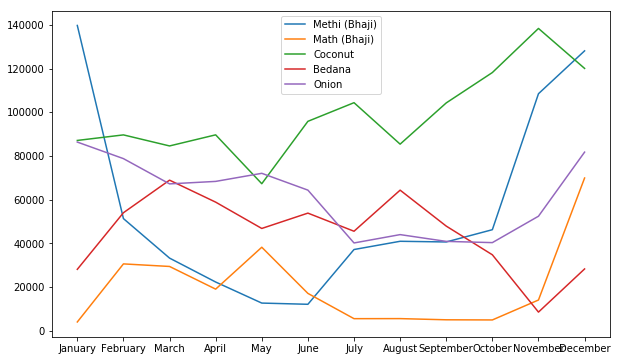

In [42]:
plt.figure(figsize=(10,6))
for i in month_wise_fluc.head().index:
    plt.plot(month_wise_fluc.loc[i][months])
plt.legend(month_wise_fluc.head().index)

### Prices of commodities affected month wise

In [43]:
month_wise_price = pd.DataFrame(monthly_data.groupby(by=['Commodity','Month'])['modal_price'].mean()).pivot_table(values='modal_price', index='Commodity', columns='Month')

In [44]:
month_wise_price.fillna(0, inplace=True)

In [45]:
month_wise_price.head()

Month,April,August,December,February,January,July,June,March,May,November,October,September
Commodity,,,,,,,,,,,,
Amba Koy,0.000000,0.000000,0.0000,0.000000,0.000000,4750.000000,3750.000000,0.000000,1500.000000,0.000000,0.000000,0.000000
Ambat Chuka,194.500000,760.400000,135.0000,0.000000,0.000000,350.333333,783.333333,0.000000,0.000000,699.500000,624.400000,389.000000
Amla,0.000000,0.000000,1519.0000,1625.000000,1491.666667,0.000000,0.000000,1800.000000,0.000000,1479.200000,1690.000000,1911.000000
Apple,9595.333333,7999.217391,4802.1875,5920.555556,5908.812500,9969.176471,11030.750000,7606.933333,9870.333333,6256.923077,6186.600000,7057.655172
Arvi,2388.500000,1923.250000,2092.0000,2253.750000,2226.666667,2109.250000,2321.000000,2224.250000,2350.200000,2170.833333,2100.333333,2080.500000


In [46]:
month_wise_price['Standard_dev'] = month_wise_price.std(axis=1)

** Here the table contains the mean *Price* data of a commodity in a given month for all the year available i.e 2015 and 2016.
Going by the concept that all the commodities above the mean of the standard deviation are affected by months in the year **

In [47]:
month_wise_price_median = month_wise_price['Standard_dev'].median()

In [48]:
commodities_price_affected_month = month_wise_price[month_wise_price['Standard_dev'] > month_wise_price_median]

In [49]:
commodities_price_not_affected_month = month_wise_price[month_wise_price['Standard_dev'] < month_wise_price_median]

In [50]:
month_wise_price_fluc = month_wise_price.sort_values('Standard_dev', ascending=False)

In [51]:
month_wise_price_fluc = month_wise_price_fluc[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Standard_dev']]

In [52]:
month_wise_price_fluc = month_wise_price_fluc.round(2)

In [53]:
month_wise_price_fluc.head()

Month,January,February,March,April,May,June,July,August,September,October,November,December,Standard_dev
Commodity,,,,,,,,,,,,,
Cow,27500.0,20000.00,0.0,0.0,0.00,55000.00,0.00,2000.0,61000.0,7000.0,0.0,0.0,22310.95
Jui,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,53333.0,0.0,0.0,0.0,15395.91
Buffalo,25000.0,35100.00,6000.0,45750.0,0.00,35000.00,26000.00,35000.0,31500.0,32250.0,22000.0,27125.0,12763.96
Mango,40250.0,20648.25,14332.8,6525.8,4635.27,3378.67,2967.88,3038.5,0.0,0.0,2500.0,0.0,11858.07
Kagda,20333.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,28000.0,0.0,0.0,5000.0,9464.75


In [54]:
month_wise_price_fluc.to_csv('./final_data/Commodity_price_affected_month_wise.csv')

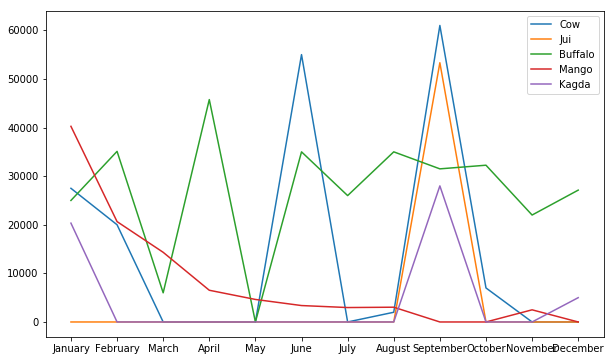

In [55]:
# top 5 commodity price affected throughout the year
plt.figure(figsize=(10,6))
for i in month_wise_price_fluc.head().index:
    plt.plot(month_wise_price_fluc.loc[i][['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']])
plt.legend(month_wise_price_fluc.head().index)

### Task 1 : To filter the outliers
Filtering the outliers will be removing the data not in the range of first and third quartile.

In [56]:
# list of kharif, rabi and other crops
kharif = df[df['Type'] == 'Kharif Crops']['Commodity'].unique()
rabi = df[df['Type'] == 'Rabi Crops']['Commodity'].unique()
others = df[df['Type'] == 'Other Crops']['Commodity'].unique()

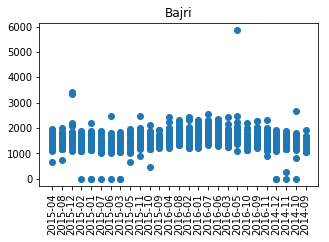

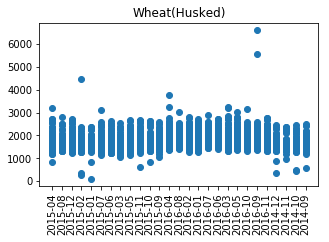

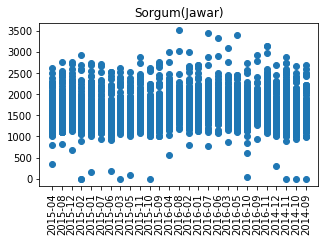

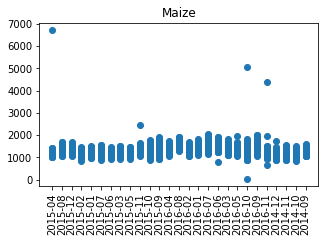

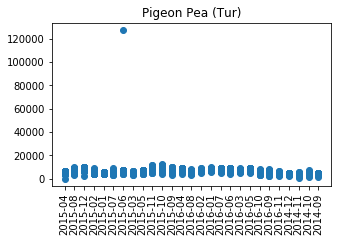

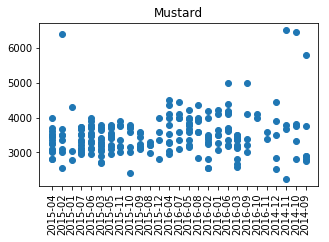

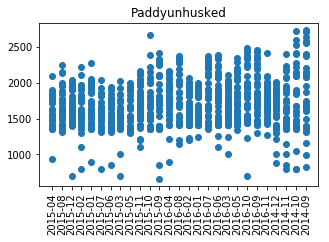

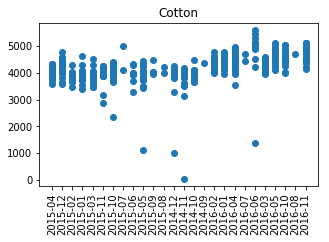

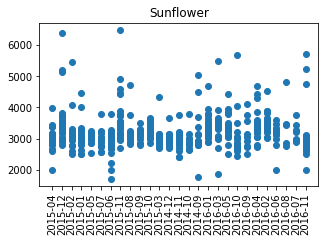

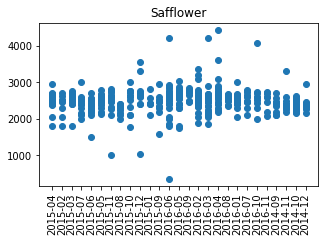

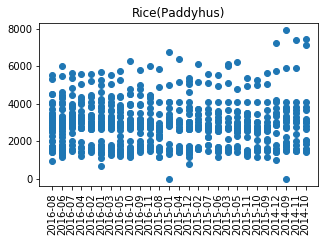

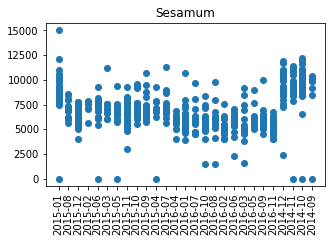

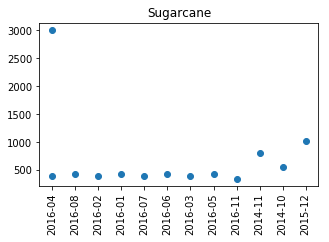

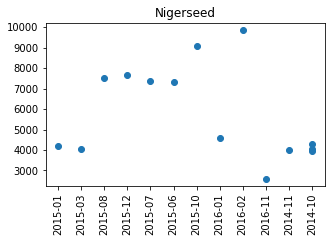

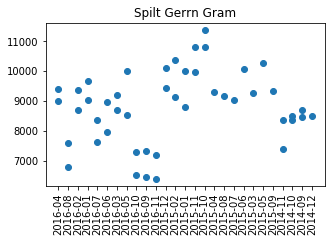

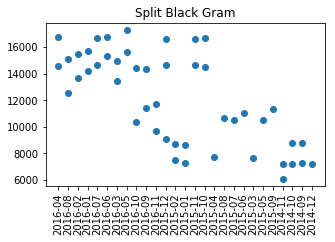

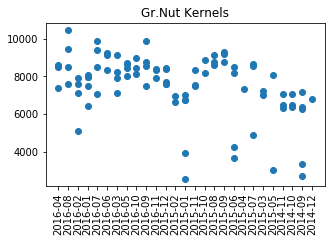

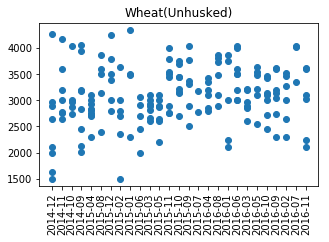

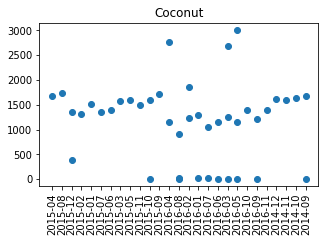

In [57]:
# plotting raw modal prices for all crops 
for i in df['Commodity'].unique():
    b = df[df['Commodity'] == i]
    plt.figure(figsize=(5,3))
    plt.scatter(b['date'], b['modal_price'])
    plt.xticks(rotation=90)
    plt.title(i)
    plt.show()

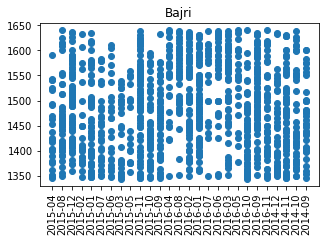

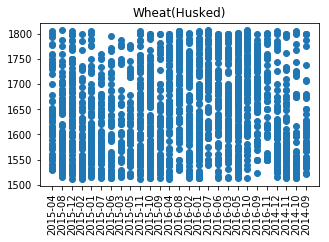

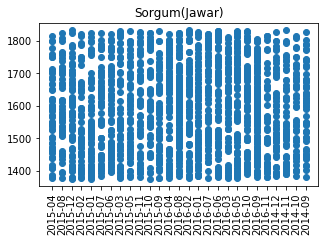

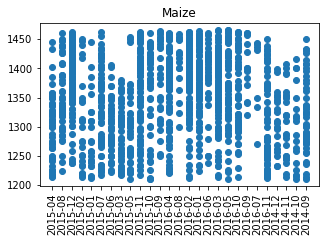

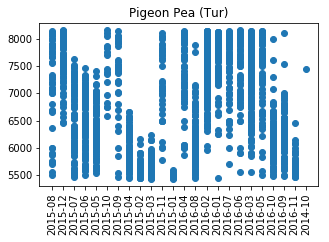

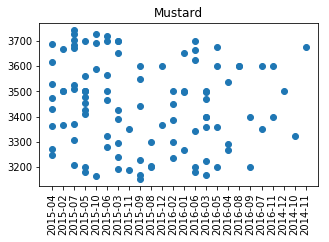

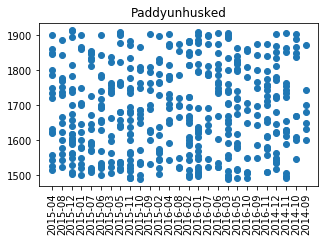

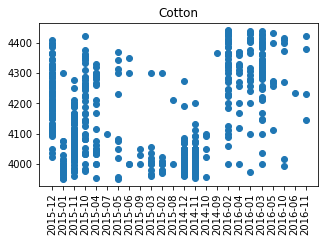

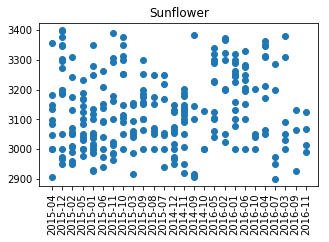

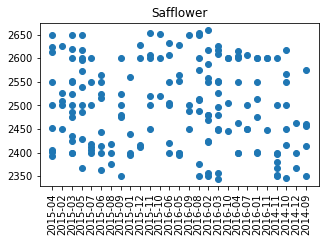

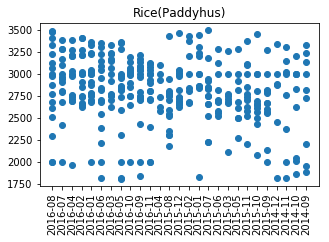

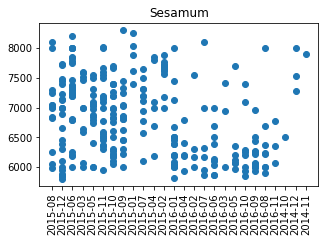

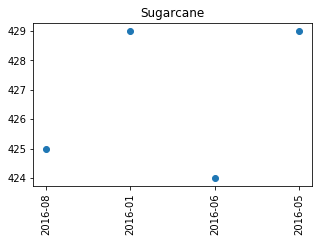

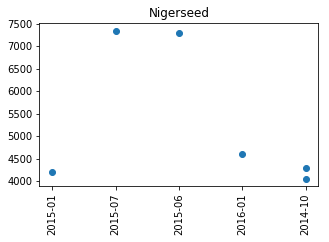

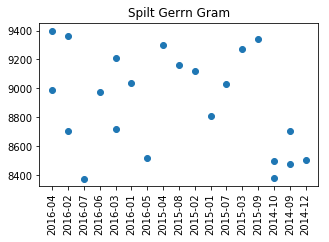

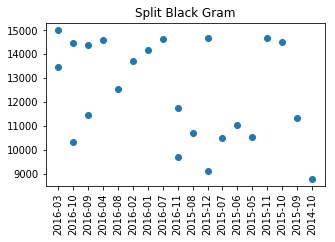

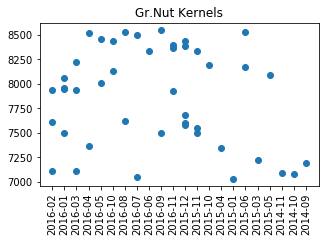

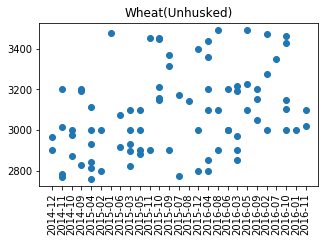

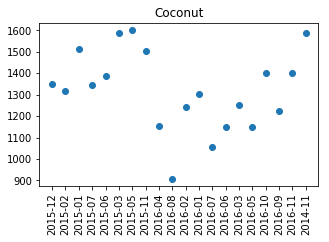

In [58]:
# filtering outliers by excluding the values outside the range of 1st and 3rd quartile
for i in df['Commodity'].unique():
    b = df[df['Commodity'] == i]
    quartile = np.percentile(b['modal_price'], [25,75])
    c = b[(b['modal_price']>quartile[0]) & (b['modal_price']<quartile[1])]
    plt.figure(figsize=(5,3))
    plt.scatter(c['date'], c['modal_price'])
    plt.xticks(rotation=90)
    plt.title(i)
    plt.show()  

In [59]:
# Considering for one APMC i.e Ahmednagar
ahmednagar = df[df['APMC'] == 'Ahmednagar']

In [60]:
month_wise_price = pd.DataFrame(df.groupby(by=['APMC','Commodity','Month'])['modal_price'].mean()).pivot_table(values='modal_price', index=['APMC','Commodity'], columns='Month')

In [61]:
month_wise_price.fillna(0, inplace=True)

In [62]:
month_wise_price = month_wise_price.round(2)

In [63]:
month_wise_price['Standard_dev'] = month_wise_price.std(axis=1)

In [64]:
month_wise_price_fluctuation = month_wise_price.sort_values('Standard_dev', ascending=False)

In [65]:
month_wise_price_fluctuation = month_wise_price_fluctuation[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Standard_dev']]

In [66]:
month_wise_price_fluctuation = month_wise_price_fluctuation.round(2)

In [67]:
month_wise_price_fluctuation.head()

,Month,January,February,March,April,May,June,July,August,September,October,November,December,Standard_dev
APMC,Commodity,,,,,,,,,,,,,
Devala,Pigeon Pea (Tur),6045.5,5807.5,5961.0,6168.0,6517.0,67236.5,7550.0,5905.0,5575.0,8509.0,6021.33,6010.0,17590.62
Beed,Sesamum,10580.0,0.0,0.0,6191.0,0.0,6500.0,0.0,0.0,0.0,10150.0,9782.00,11670.0,5013.56
Kalyan,Sesamum,12825.0,0.0,10203.5,0.0,9000.0,8000.0,10476.5,9158.5,10333.5,0.0,0.00,5950.0,4942.84
Ausa,Sesamum,9001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9500.0,9003.0,8573.00,8818.0,4628.10
Barshi,Sesamum,11000.0,0.0,0.0,0.0,0.0,6101.0,5700.0,0.0,0.0,9850.0,8500.00,8350.0,4527.81


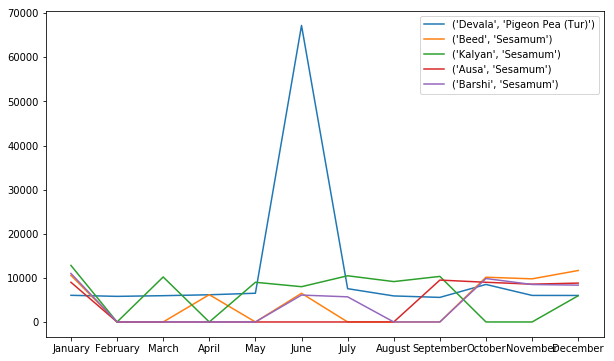

In [68]:
plt.figure(figsize=(10,6))
for i in month_wise_price_fluctuation.head().index:
    plt.plot(month_wise_price_fluctuation.loc[i][months])
plt.legend(month_wise_price_fluctuation.head().index)

In [69]:
df_n = df.set_index(['APMC','Commodity', 'Year'])

In [70]:
df_n.head()

,,,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,Type,msprice,msp_filter
APMC,Commodity,Year,,,,,,,,,,,
Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
Akole,Bajri,2015,April,52,1357,1800,1525,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
Jamkhed,Bajri,2015,April,164,1304,1446,1375,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
Kopargaon,Bajri,2015,April,354,1164,1469,1401,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1
Newasa,Bajri,2015,April,32,1282,1293,1286,2015-04,Ahmadnagar,Maharashtra,Kharif Crops,1275.0,1


In [71]:
df_n['date'] = pd.to_datetime(df_n['date'])

In [72]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20862 entries, (Ahmednagar, Bajri, 2015) to (Ulhasnagar, Sugarcane, 2015)
Data columns (total 11 columns):
Month              20862 non-null object
arrivals_in_qtl    20862 non-null int64
min_price          20862 non-null int64
max_price          20862 non-null int64
modal_price        20862 non-null int64
date               20862 non-null datetime64[ns]
district_name      20862 non-null object
state_name         20862 non-null object
Type               20862 non-null object
msprice            18752 non-null float64
msp_filter         20862 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 1.8+ MB


### Task 2: Considering 'Bajri' of Ahmednagar APMC we will check the additive and multiplicative seasonal effect and get the deseasonlised price of commodity

In [73]:
ahmednagar = month_wise_price.xs('Ahmednagar', level=0)

In [74]:
ahmednagar

Month,April,August,December,February,January,July,June,March,May,November,October,September,Standard_dev
Commodity,,,,,,,,,,,,,
Bajri,1669.0,1686.0,1716.0,1674.5,1615.0,1578.0,1670.5,1662.5,1923.0,1618.67,1479.0,1619.0,103.695981
Maize,1374.0,1725.5,1490.0,1461.0,1398.5,1406.0,1574.5,1316.0,1624.0,1389.33,1545.5,1758.0,142.326800
Mustard,3708.5,0.0,0.0,3501.0,4300.0,3725.0,3900.0,0.0,0.0,3800.00,0.0,0.0,2004.381354
Pigeon Pea (Tur),6281.0,5900.5,8271.0,6020.0,6565.0,6250.0,6908.0,5798.5,7700.0,5964.00,7801.5,6175.0,842.274207
Sorgum(Jawar),2009.5,1868.5,1960.0,1975.0,2079.0,2014.0,1923.5,1982.0,2046.0,2198.00,1881.0,1944.0,90.276207
Wheat(Husked),1865.0,1706.5,1883.0,1841.5,1838.0,1664.0,1901.0,1766.0,2824.0,1843.33,1770.0,1794.0,302.129317


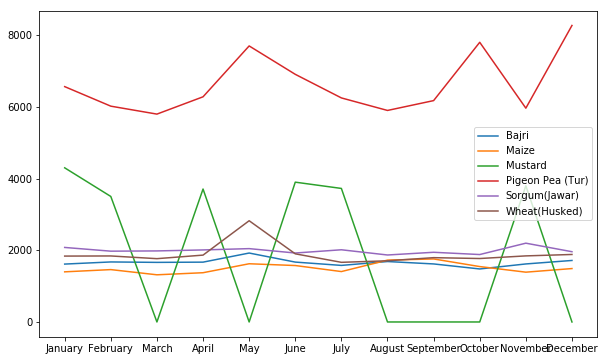

In [75]:
# to check the change in price of all commodity in Ahmednagar APMC throughout the year
plt.figure(figsize=(10,6))
for i in ahmednagar.index:
    plt.plot(ahmednagar.loc[i][months])
plt.legend(ahmednagar.index)

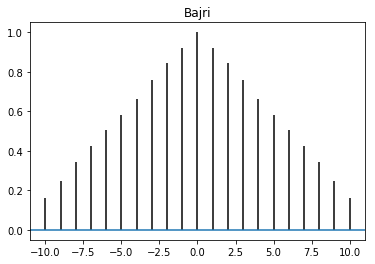

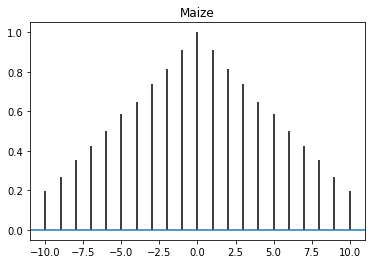

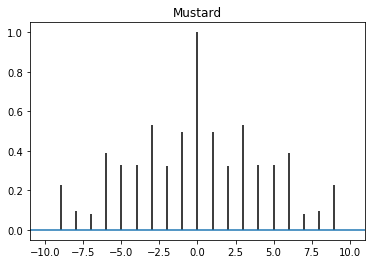

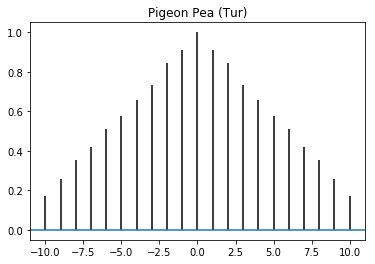

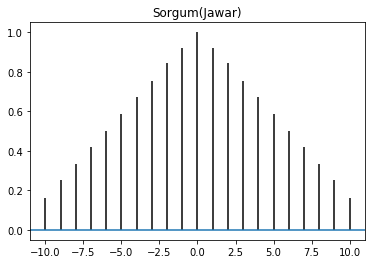

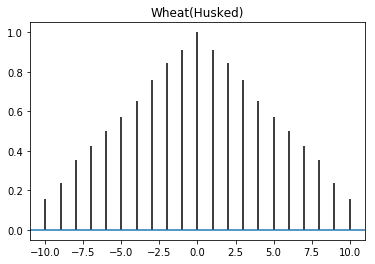

In [76]:
# to check if there is any trend and relation in the changing price of all crops in Ahmednagar APMC 
for i in ahmednagar.index:
    plt.acorr(ahmednagar.loc[i])
    plt.title(i)
    plt.show()

** Above plot shows there is a time dependant pattern existing in the time series data for almost all crops in Ahmednagar APMC**

In [77]:
APMC_list = df.APMC.unique()
APMC_list

array(['Ahmednagar', 'Akole', 'Jamkhed', 'Kopargaon', 'Newasa',
       'Pathardi', 'Rahata', 'Rahuri', 'Rahuri-Vambori', 'Sangamner',
       'Shevgaon', 'Shevgaon-Bodhegaon', 'Shrirampur', 'Shrigonda',
       'Shrirampur-Belapur', 'Akola', 'Balapur', 'Amarawati', 'Achalpur',
       'Gangapur', 'Kannad', 'Lasur Station', 'Paithan', 'Sillod',
       'Sillod-Bharadi', 'Vaijapur', 'Aurangabad', 'Beed', 'Gevrai',
       'Kada', 'Kada (Ashti)', 'Kej', 'Kille Dharur', 'Majalgaon',
       'Parli-Vaijnath', 'Ambejogai', 'Malkapur', 'Nandura', 'Shegaon',
       'Khamgaon', 'Sindkhed Raja', 'Lonar', 'Dhule', 'Dondaicha',
       'Sakri', 'Shirpur', 'Dondaicha-Sindkheda', 'Bhusaval', 'Chopda',
       'Jalgaon', 'Raver', 'Amalner', 'Chalisgaon', 'Pachora', 'Parola',
       'Yawal', 'Jalna', 'Ambad(Vadi Godri)', 'Jalna-Badnapur', 'Partur',
       'Ashti (Jalna)', 'Bhokardan', 'Bhokardan-Pimpalgaon Renu',
       'Ghansawangi', 'Mantha', 'Kolhapur-Laxmipuri', 'Latur', 'Ahmedpur',
       'Ausa', 'Bhokar

In [78]:
crops

array(['Bajri', 'Wheat(Husked)', 'Sorgum(Jawar)', 'Maize',
       'Pigeon Pea (Tur)', 'Mustard', 'Paddyunhusked', 'Cotton',
       'Sunflower', 'Safflower', 'Rice(Paddyhus)', 'Sesamum', 'Sugarcane',
       'Nigerseed', 'Spilt Gerrn Gram', 'Split Black Gram',
       'Gr.Nut Kernels', 'Wheat(Unhusked)', 'Coconut'], dtype=object)

#### Selecting a random APMC and a crop grown there
Here Bajri crop of ahmednagar APMC is selected to check seasonality trend and get seasonalised price

In [79]:
ahmednagar_bajri = df_n.xs('Ahmednagar', level=0).xs('Bajri', level=0)

In [80]:
ahmednagar_bajri = ahmednagar_bajri[['date', 'modal_price', 'msprice']]

In [81]:
ahmednagar_bajri.head()

,date,modal_price,msprice
Year,,,
2015,2015-04-01,1463,1275.0
2015,2015-08-01,1615,1275.0
2015,2015-12-01,1716,1275.0
2015,2015-02-01,1650,1275.0
2015,2015-01-01,1618,1275.0


In [82]:
ahmednagar_bajri.set_index('date', inplace=True)

In [83]:
ahmednagar_bajri.sort_index(inplace=True)

In [84]:
ahmednagar_bajri.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 2014-09-01 to 2016-11-01
Data columns (total 2 columns):
modal_price    23 non-null int64
msprice        23 non-null float64
dtypes: float64(1), int64(1)
memory usage: 552.0 bytes


In [85]:
ahmednagar_bajri.head()

,modal_price,msprice
date,,
2014-09-01,1575,1250.0
2014-11-01,1629,1250.0
2015-01-01,1618,1275.0
2015-02-01,1650,1275.0
2015-03-01,1525,1275.0


In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [87]:
# Additive decomposition of time series data of a particular crop 'Bajri' of a particular APMC 'Ahmednagar'
decomposition_add = seasonal_decompose(ahmednagar_bajri['modal_price'], model='additive', freq=10)

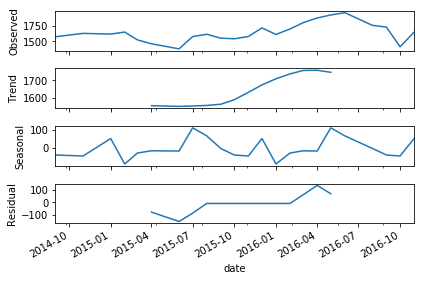

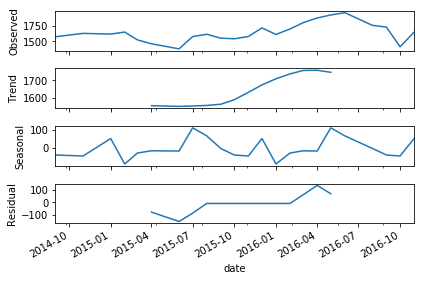

In [88]:
decomposition_add.plot()

In [89]:
# Multiplicative decomposition of time series data of a particular crop 'Bajri' of a particular APMC 'Ahmednagar'
decomposition_mul = seasonal_decompose(ahmednagar_bajri['modal_price'], model='multiplicative', freq=10)

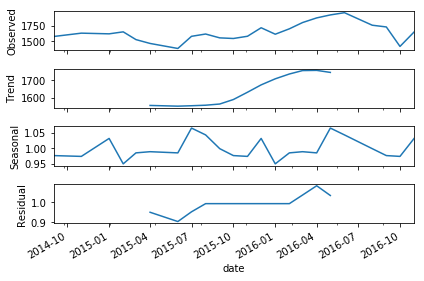

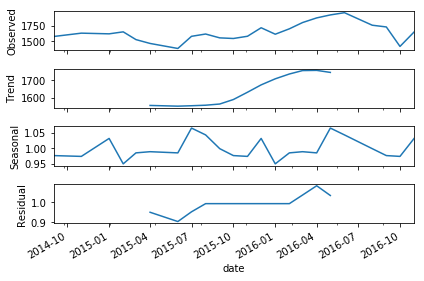

In [90]:
decomposition_mul.plot()

In [91]:
ahmednagar_bajri['Trend_additive'] = decomposition_add.trend
ahmednagar_bajri['Trend_multiplicative'] = decomposition_mul.trend

ahmednagar_bajri['Sesonal_additive'] = decomposition_add.seasonal
ahmednagar_bajri['Sesonal_multiplicative'] = decomposition_mul.seasonal

In [92]:
ahmednagar_bajri.head()

,modal_price,msprice,Trend_additive,Trend_multiplicative,Sesonal_additive,Sesonal_multiplicative
date,,,,,,
2014-09-01,1575,1250.0,NaN,NaN,-37.835,0.976582
2014-11-01,1629,1250.0,NaN,NaN,-43.335,0.973960
2015-01-01,1618,1275.0,NaN,NaN,51.765,1.031975
2015-02-01,1650,1275.0,NaN,NaN,-86.685,0.949886
2015-03-01,1525,1275.0,NaN,NaN,-27.085,0.985351


### Task 3: Comparing the deseasonlised price, raw price and MSP

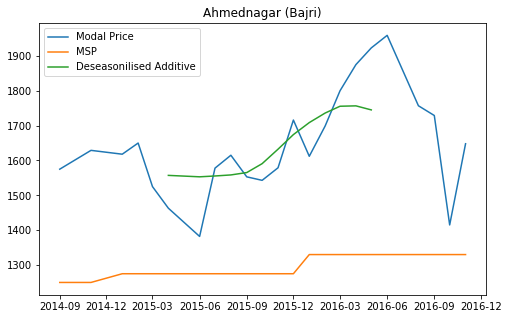

In [93]:
plt.figure(figsize=(8,5))
plt.plot(ahmednagar_bajri['modal_price'])
plt.plot(ahmednagar_bajri['msprice'])
plt.plot(ahmednagar_bajri['Trend_additive'])
plt.title('Ahmednagar (Bajri)')
plt.legend(['Modal Price', 'MSP', 'Deseasonilised Additive'])

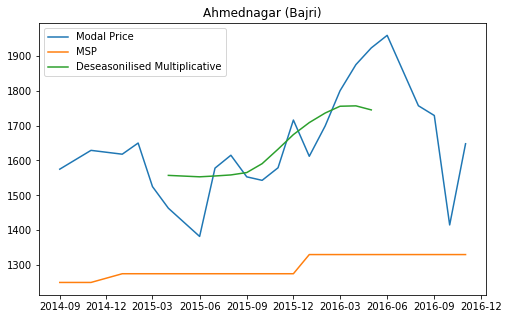

In [94]:
plt.figure(figsize=(8,5))
plt.plot(ahmednagar_bajri['modal_price'])
plt.plot(ahmednagar_bajri['msprice'])
plt.plot(ahmednagar_bajri['Trend_multiplicative'])
plt.title('Ahmednagar (Bajri)')
plt.legend(['Modal Price', 'MSP', 'Deseasonilised Multiplicative'])

In [95]:
new = df

### Task 4: Crops having highest fluctuation throughout the year can be found out from standard deviation
### Higher the standard deviation, higher the fluctuation of price and vice versa

In [96]:
month_wise_price.sort_values(by='Standard_dev', ascending=False).head()

,Month,April,August,December,February,January,July,June,March,May,November,October,September,Standard_dev
APMC,Commodity,,,,,,,,,,,,,
Devala,Pigeon Pea (Tur),6168.0,5905.0,6010.0,5807.5,6045.5,7550.0,67236.5,5961.0,6517.0,6021.33,8509.0,5575.0,17590.618865
Beed,Sesamum,6191.0,0.0,11670.0,0.0,10580.0,0.0,6500.0,0.0,0.0,9782.00,10150.0,0.0,5013.557023
Kalyan,Sesamum,0.0,9158.5,5950.0,0.0,12825.0,10476.5,8000.0,10203.5,9000.0,0.00,0.0,10333.5,4942.843311
Ausa,Sesamum,0.0,0.0,8818.0,0.0,9001.0,0.0,0.0,0.0,0.0,8573.00,9003.0,9500.0,4628.096450
Barshi,Sesamum,0.0,0.0,8350.0,0.0,11000.0,5700.0,6101.0,0.0,0.0,8500.00,9850.0,0.0,4527.807526


In [97]:
month_wise_price.to_csv('./final_data/Price_fluctuation_throughout_year.csv')

### Doing the same for Season Type based also

In [98]:
pd.DataFrame(df.groupby(by=['APMC','Commodity','Type'])['modal_price'].mean()).pivot_table(values='modal_price', index=['APMC','Commodity'], columns='Type').head()

Type                       Kharif Crops  Other Crops  Rabi Crops
APMC     Commodity                                              
Aamgaon  Paddyunhusked      1550.111111          NaN         NaN
Aarni    Pigeon Pea (Tur)   7246.523810          NaN         NaN
         Sorgum(Jawar)      1138.500000          NaN         NaN
         Wheat(Husked)              NaN          NaN      1355.0
Achalpur Bajri              1683.000000          NaN         NaN

### So we see that the above technique of standard deviation wont work for Season type as Kharif crop wont have data in Rabi or Other crops and vice versa
### So for fluctuation we can check the price in specific seasons 

#### fluctuation = max_price - min_price

In [99]:
new['fluctuation'] = new['max_price'] - new['min_price']

In [100]:
new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20862 entries, 0 to 20861
Data columns (total 15 columns):
APMC               20862 non-null object
Commodity          20862 non-null object
Year               20862 non-null int64
Month              20862 non-null object
arrivals_in_qtl    20862 non-null int64
min_price          20862 non-null int64
max_price          20862 non-null int64
modal_price        20862 non-null int64
date               20862 non-null object
district_name      20862 non-null object
state_name         20862 non-null object
Type               20862 non-null object
msprice            18752 non-null float64
msp_filter         20862 non-null int64
fluctuation        20862 non-null int64
dtypes: float64(1), int64(7), object(7)
memory usage: 2.5+ MB


In [101]:
new['Relative_fluctuation'] = ((new['fluctuation'] / ((new['max_price'] + new['min_price']) / 2)) * 100)

In [102]:
new['Relative_fluctuation'] = new['Relative_fluctuation'].fillna(0).apply(lambda x: math.ceil(x))

In [103]:
new.sort_values(by='fluctuation', ascending=False, inplace=True)

In [104]:
new.columns

Index(['APMC', 'Commodity', 'Year', 'Month', 'arrivals_in_qtl', 'min_price',
       'max_price', 'modal_price', 'date', 'district_name', 'state_name',
       'Type', 'msprice', 'msp_filter', 'fluctuation', 'Relative_fluctuation'],
      dtype='object')

In [105]:
final = new[['APMC', 'Commodity', 'Year', 'date', 'modal_price', 'Type', 'msprice', 'fluctuation', 'Relative_fluctuation']]

In [106]:
final.reset_index(inplace=True, drop=True)

In [107]:
final.head()

,APMC,Commodity,Year,date,modal_price,Type,msprice,fluctuation,Relative_fluctuation
0,Umarkhed,Pigeon Pea (Tur),2016,2016-09,6000,Kharif Crops,4625.0,55400,166
1,Shegaon,Sesamum,2015,2015-10,6507,Kharif Crops,4700.0,10286,89
2,Barshi,Sesamum,2014,2014-10,10500,Kharif Crops,4600.0,9425,163
3,Gevrai,Pigeon Pea (Tur),2015,2015-03,5536,Kharif Crops,4425.0,8449,96
4,Nilanga,Pigeon Pea (Tur),2015,2015-08,8861,Kharif Crops,4425.0,7204,61


In [108]:
final.to_csv('./final_data/Price_fluctuation_season_wise.csv', index=False)